# Physics-based Machine Learning for Copernicus Sentinel-5P Methane Retrieval

<hr>

## Introduction

Physically-based `radiative transfer models (RTMs)` help us to understand the physical processes that occur at the Earth's surface and within the Earth's atmosphere. Atmospheric RTMs allow us to model the light interactions with the atmosphere, and are often used in the retrieval of greenhouse gas concentrations through model inversions. RTMs can range from simple to complex. More advanced RTMs are often computationally heavy and can take a long time to run, often making them unfeasible to use in operational contexts.

Replacing these advanced RTMs with `emulators`, or statistical models that approximate the advanced RTM, can be very useful, as they can dramatically improve the computational efficiency and speed up retrievals of greenhouse gas concentrations, which is advantageous particularly in operational contexts. 

Emulators essentially "learn the physics" of the advanced RTM, and are generated using a statistical model that learns the output modelled by a RTM, given a set of atmospheric parameters. Accordingly, Machine Learning approaches can be used as the statistical model that approximates the RTM. 

This notebook takes you through an example of generating an emulator of an atmospheric RTM called `"LINTRAN"`, that is used in operational retrieval schemes for methane (CH<sub>4</sub>). 

## Data

A “retrieval algorithm” is used to convert the spectra captured by TROPOMI (known as Level 1 data) into trace gas concentrations (known as Level 2 data). An example of such an algorithm is the `RemoTeC algorithm` ([Butz et al. 2012](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL047888); [Hu et al. 2016](https://amt.copernicus.org/articles/9/5423/2016/)).

`RemoTeC` simulates a realistic approximation of the `Sentinel-5P TROPOMI` bands in the Visible, Near-Infrared (NIR) and Shortwave-InfraRed (SWIR) spectrum. It is currently the operational method for methane retrievals from S5P/TROPOMI.

The core of the RemoTeC algorithm is the LINTRAN Radiative Transfer Model ([Hasekamp and Landgraf 2002](https://www.sciencedirect.com/science/article/abs/pii/S0022407301002473)), which simulates synthetic spectra based on a set of input atmospheric, spectroscopic, surface and instrument properties/assumptions. Some further information about the algorithm can be found in the following papers: 

* [Toward accurate CO2 and CH4 observations from GOSAT](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL047888)
* [Impact of aerosol and thin cirrus on retrieving and validating XCO2 from GOSAT shortwave infrared measurements](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/jgrd.50332)
* [Methane retrievals from Greenhouse Gases Observing Satellite (GOSAT) shortwave infrared measurements: Performance comparison of proxy and physics retrieval algorithms](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JD017549)

In order to emulate the LINTRAN RTM, 50,000 simulations have been performed by Dr. J. Landgraf at the Dutch Space Research Organisation (SRON). The atmospheric parameter input into `RemoTeC` are designed to cover the range of atmospheric conditions that S5P/TROPOMI is expected to encounter, so that the emulator is capable of approximating both realistic atmospheric conditions and S5P/TROPOMI measurements. 

The table below indicates the key atmospheric parameters and their value ranges which were used as input into the LINTRAN model to build the emulator training dataset: 


| Parameter | Variation/distribution | Source |
| --- | --- | --- |
| **SZA** | 0-70 deg | |
| **Albedo** | 0.01, 0.1, 0.3, 0.5, 0.8 | ADAM Database *(Muller et al. 2013)* |
| **CH4 profile** | Arctic, mid-latitude & tropical cond. | TM5 Model [Hu et al. 2016](https://amt.copernicus.org/articles/9/5423/2016/) |
| **CO profile** | Arctic, mid-latitude & tropical cond. | TM5 Model [Hu et al. 2016](https://amt.copernicus.org/articles/9/5423/2016/) |
| **H20 profile** | Arctic, mid-latitude & tropical cond. |  ECMWF [Hu et al. 2016](https://amt.copernicus.org/articles/9/5423/2016/) |
| **Aerosols**  | Five different aerosol types. | ECHAM-HAM |
| **Temperature** | Arctic, mid-latitude & tropical cond. | ECMWF [Hu et al. 2016](https://amt.copernicus.org/articles/9/5423/2016/)|
| **Pressure** | Arctic, mid-latitude & tropical cond. | ECMWF [Hu et al. 2016](https://amt.copernicus.org/articles/9/5423/2016/)|

## Further resources

* [Learning Surrogates of a Radiative Transfer Model for the Sentinel-5P Satellite](https://link.springer.com/chapter/10.1007/978-3-030-61527-7_15)
* [The operational methane retrieval algorithm for TROPOMI](https://amt.copernicus.org/articles/9/5423/2016/)
* [Toward accurate CO<sub>2</sub> and CH<sub>4</sub> observations from GOSAT](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL047888)
* [Physics-Based machine learning for Copernicus Sentinel-5P methane retrieval](https://philab.phi.esa.int/usecases/physics-based-machine-learning-for-copernicus-sentinel-5p-methane-retrieval/)

<hr>

## Notebook outline


* [1 - Load the sample data](#data_load_5c)
* [2 - Split the sample data into subsets for training and testing](#split_training_test_5c)
* [3 - Standardization (Scaling) of the input and output training data](#data_scaling_5c)
* [4 - Apply Principal Component Analysis (PCA) to the output spectra](#pca_5c)
* [5 - Setup and training of the Neural Network](#train_neural_network_5c)
* [6 - Predict with and evaluate the performance of the trained neural network](#predict_5c)
* [7 - Visualise the results](#visualize_5c)


<hr>

#### Import libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import pickle

import pylab as plt
import seaborn as sns

#### Helper functions

In [2]:
def load_data(outfile):
    
    npfile = np.load(outfile)
    state_vector = npfile["inputs"]
    wl = npfile["wavelength"]
    spectra = npfile["output"]
    n_dataset = len(spectra)
    n_params = len(state_vector[0])
    
    return state_vector, wl, spectra, n_dataset, n_params

def rmse(actual, predicted):   
    return np.sqrt(np.mean((predicted - actual)**2,axis=1))

def nrmse(actual, predicted):  
    normalised_rmse = rmse(actual, predicted) / (actual.max() - actual.min())
    return normalised_rmse

<hr>

## <a id='data_load_5c'></a>1. Load the sample data

The first step is to load the dataset, which shall be used to train the neural network. The file [Methane_Dataset](./Methane_Dataset.npz) is a `npz` file, which is a zipped archive of different variables. 

The file contains the following parameters: 
* `state_vector` : atmospheric parameters that are used as input for the RTM model
* `wl`: wavelengths of the output radiance values in the TROPOMI SWIR band from 2304 to 2386 nm 
* `spectra`: radiance spectra output from the RTM model
* `n_dataset`: size of the dataset (number of simulations)
* `n_params`: number of atmospheric parameters used in the study

You can use the function`load_data()` to load the file and retrieve the parameters individually.

In [3]:
state_vector, wl, spectra, n_dataset, n_params = load_data('./Methane_Dataset.npz')

In [4]:
state_vector.shape, wl.shape, spectra.shape, n_dataset, n_params

((50000, 125), (834,), (50000, 834), 50000, 125)

<br>

Let us visualise an example of the LINTRAN simulated TROPOMI radiance spectra (top of atmosphere radiance) in the SWIR band, which is the band we are using to retrieve Methane. We can see certain absorption and scattering features resulting from gases and other atmospheric parameters such as pressure and temperature. 

Text(0.5, 1.0, 'Simulated TROPOMI radiance spectra in the SWIR')

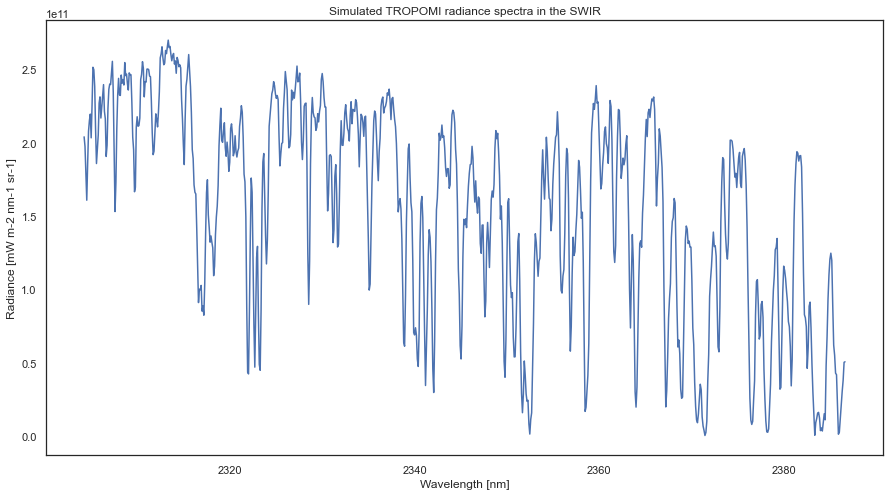

In [5]:
sns.set_theme(style="white")
plt.figure(figsize=(15,8))
plt.plot(wl, spectra[15] )
plt.xlabel('Wavelength [nm]')
plt.ylabel('Radiance [mW m-2 nm-1 sr-1]')
plt.title("Simulated TROPOMI radiance spectra in the SWIR")

<br>

## <a id='split_training_test_5c'></a>2. Split the sample data into subsets for training and testing

The next step is to split the sample data into `training` and `validation` subsets.

The Neural Network shall be trained based on the `state_vector` information as input parameter (`X`) and the `spectra` information as output parameter (`y`). Let us use 5% of the sample data for `validation` and 5% for `testing`.

In [6]:
samples_train, samples_validation, spectra_train, spectra_validation = train_test_split(state_vector, 
                                                                                    spectra, 
                                                                                    test_size=0.2, 
                                                                                    random_state=0)

samples_validation, samples_test, spectra_validation, spectra_test = train_test_split(samples_validation, 
                                                                                    spectra_validation, 
                                                                                    test_size=0.5, 
                                                                                    random_state=0)

If you inspect the resulting arrays, you see that out of the 50,000 simulations, 40,000 are used for training, 5000 for validation and 5000 for testing.

In [7]:
samples_train.shape, spectra_validation.shape, samples_test.shape

((40000, 125), (5000, 834), (5000, 125))

<br>

## <a id='data_scaling_5c'></a>3. Standardization (Scaling) of the input and output training data

`Standardization` or `Scaling` of the training data is a common operation in Machine Learning, especially if you have diverse input parameters with different data ranges. It is a common requirement for many Machine Learning estimators, as they might behave badly if the individual features do not ook like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

Different functions can be used for standardization or scaling, where the optimal scaling function depends on the type and distribution of the dataset. For this reason, it is advisable to have a look at the distributions of the input data. 

In the case of our data, since most of our data have distributions that are unimodal or bimodal with either tail heavy or normal distributions, we will scale the data by centring the values around the mean with a unit standard deviation. This removes the mean and scales the data to unit variance. Other scaling techniques exist, such as data normalization, in which values are shifted and rescaled so that they end up ranging between 0 and 1, otherwise known as min-max scaling. This approach is good to use when you know that the distribution of your data does not follow a Gaussian distribution. 


Below, the scaling for both output datasets, `spectra_train`, `spectra_validation` and `spectra_test`.

In [8]:
scaler_spec = StandardScaler()

scaler_spec.fit(spectra_train)
spectra_train_scale = scaler_spec.transform(spectra_train)
spectra_validation_scale = scaler_spec.transform(spectra_validation)
spectra_test_scale = scaler_spec.transform(spectra_test)

And now, the `scaling` process for the input data, `samples_train`, `samples_validation` and `samples_test`.

In [9]:
scaler = StandardScaler()
scaler.fit(samples_train)
samples_train_scale = scaler.transform(samples_train)
samples_validation_scale = scaler.transform(samples_validation)
samples_test_scale = scaler.transform(samples_test)

<br>

## <a id='pca_5c'></a> 4. Principal Component Analysis (PCA) to the output spectra

Due to the large amount of components in the input data (`spectra`), it is advisable to apply a `Principle Component Analysis (PCA)` in order to reduce `redundancy` and `colinearity` in the wavelengths.  

Below, the `PCA` constructor that is part of scikit-learn's `decomposition` module is applied to the scaled training output data (`spectra_train_scale`). Let us set the number of principal components to 20. Thus, the dimension of the scaled training output data is reduced from `(45000, 834)` to `(45000, 20)`.

In [10]:
n_components=20

pca = PCA(n_components)
scores = pca.fit(spectra_train_scale)

evals = pca.explained_variance_ratio_
evals_cs = evals.cumsum()

pca_train_data = pca.transform(spectra_train_scale)
pca_validation_data = pca.transform(spectra_validation_scale)
pca_test_data = pca.transform(spectra_test_scale)

We can see that with only 20 components, we can explain virtually all the variance.

The total explained variance with 20 components is: 0.9999934840813338


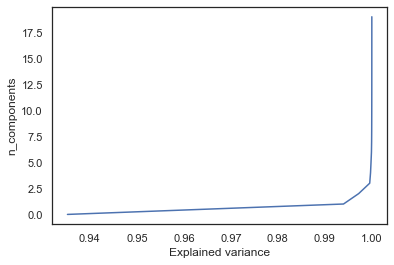

In [11]:
print(f'The total explained variance with {n_components} components is: {evals_cs[-1]}')

sns.lineplot(y=list(range(n_components)), x=evals_cs)
plt.ylabel('n_components')
plt.xlabel('Explained variance')
plt.show()

In [12]:
spectra_train_scale.shape, pca_train_data.shape

((40000, 834), (40000, 20))

<br>

## <a id='train_neural_network_5c'></a> 5. Setup and training of the Neural Network

The next step is to define the neural network architecture. This workflow makes use of the [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) class of tensorflow's module to construct the neural network.

In [13]:
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [14]:
model = Sequential([
    InputLayer((samples_train_scale.shape[1],)),
    Dense(samples_train_scale.shape[1] * 2, activation='relu'),
    Dense(samples_train_scale.shape[1] * 2, activation='relu'),
    Dense(pca_train_data.shape[1], activation='linear'),
])

In [15]:
model.compile(
    loss='mse',
    optimizer='adam',
)

In [16]:
save_best = ModelCheckpoint(
    'best_model',
    'val_loss',
    mode='min',
    save_best_only=True
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10
)

Below, the training is done using as input (`samples_train_scale`) and output (`pca_train_data`). the training will stop automatically if no improvement is done in consecutive 10 epochs (that is, 10 passes over the whole training dataset), and the model with the best performance will be saved.

> **Note:** the fitting process may can take a while. You can also go to the [next step](#predict_5c) and load a pre-trained model.

In [17]:
history = model.fit(
    samples_train_scale,
    pca_train_data, 
    epochs=100, 
    validation_data=(samples_validation_scale, pca_validation_data),
    callbacks=[save_best, early_stopping]
)

Epoch 1/100
1250/1250 [==============================] - 6s 4ms/step - loss: 3.0545 - val_loss: 0.3480
Epoch 2/100
1250/1250 [==============================] - 7s 6ms/step - loss: 0.2471 - val_loss: 0.1651
Epoch 3/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1793 - val_loss: 0.1481
Epoch 4/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1089 - val_loss: 0.0908
Epoch 5/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1050 - val_loss: 0.0725
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0940 - val_loss: 0.0983
Epoch 7/100
1250/1250 [==============================] - 5s 4ms/step - loss: 0.0822 - val_loss: 0.0591
Epoch 8/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.0682 - val_loss: 0.0899
Epoch 9/100
1250/1250 [==============================] - 4s 4ms/step - loss: 0.0724 - val_loss: 0.0564
Epoch 10/100
1250/1250 [==============================] - 5s 4ms/step - l

Below, we can see how the loss behaved for the train an validation dataset over the whole training

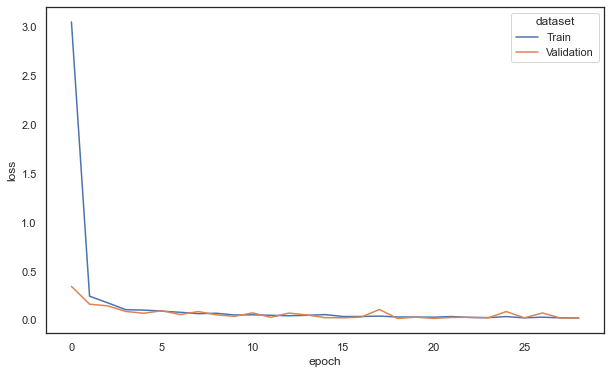

In [18]:
epochs = len(history.history['val_loss'])

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(x=list(range(epochs)), y=history.history['loss'], ax=ax)
ax = sns.lineplot(x=list(range(epochs)), y=history.history['val_loss'], ax=ax)
ax.set(xlabel='epoch', ylabel='loss')
ax.legend(title='dataset',  labels=['Train', 'Validation'])

<br>

## <a id='predict_5c'></a>6. Predict with and evaluate the performance of the trained neural network

After the training is done, the next step is to use the model and predict the spectra based on the test dataset `sample_test_scale`. As a first step, let us load the pre-trained model from the folder `best_model`.

In [19]:
model = load_model('best_model')

The next step is then to `predict` the spectra with the loaded pre-trained model.

In [20]:
pca_test_preds = model.predict(samples_test_scale)

#### Reverse the scaling and Principal Component Analysis

The predicted output spectra from the prediction step are scaled and have the Principal Component Analysis applied. For this reason, we have to `inverse` the transformations in order to evaluate the model performance. You can use the function `inverse_transform` for the classes `PCA` and `StandardScaler` to inverse the transformations for the *predicted* spectra.

First, inverse the Principal Component Analysis and then, inverse the scaling.

In [21]:
test_preds_scaled = pca.inverse_transform(pca_test_preds)
test_preds = scaler_spec.inverse_transform(test_preds_scaled)

Once the transformations of the predicted spectra have been inversed, we can evaluate the model performance by comparing the predicted spectra (`test_preds`) with the spectra from the validation dataset (`spectra_test`).

Two common metrics to measure the `error of a model` are:
* `Root Mean Square Error (RMSE)` and
* `Normalized Root Mean Square Error (nRMSE)`

We have defined two functions for both metrics at the beginning of the workflow. Both functions (`rmse()` and `nrmse()`) take the validation and predicted spectra as keyword arguments.



In [22]:
rrmse = rmse(spectra_test, test_preds)
nRMSE = nrmse(spectra_test, test_preds)

mean_rmse = np.mean(rrmse)
mean_nRMSE = np.mean(nRMSE)

print("RMSE = {:.2e}".format(mean_rmse))
print("Normalised RMSE = %s" %mean_nRMSE)

RMSE = 5.69e+10
Normalised RMSE = 0.002731087166378409


<br>

## <a id='visualize_5c'></a> 7. Visualise the results

The last step is to visualise the predicted results and compare it visually with the model output. First, we can visualize the outputs of the radiance spectra, from both, the LINTRAN RTM model and the predicted one from the Neural Network.

Visualizing validation idx 126


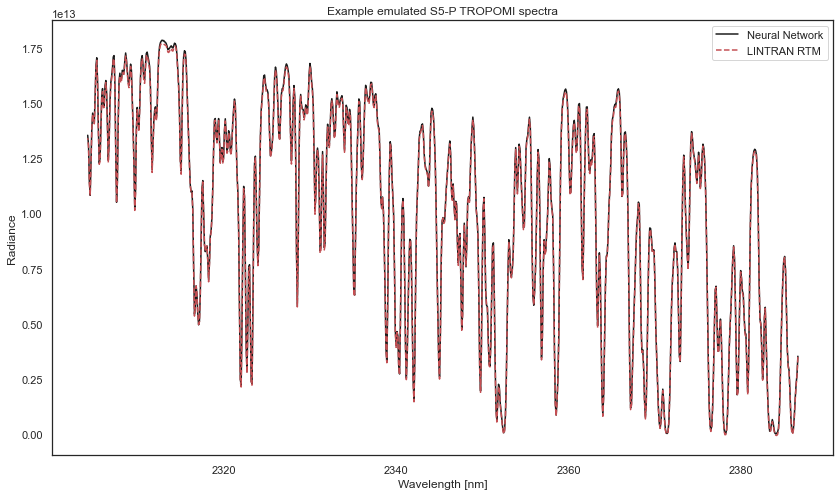

In [23]:
idx = np.random.randint(0, np.shape(test_preds)[0])
fig2 = plt.figure(1)
fig2.set_size_inches(14,8)
print(f'Visualizing validation idx {idx}')
plt.plot(wl, spectra_test[idx],'k-')
plt.plot(wl, test_preds[idx], "r--")
plt.xlabel('Wavelength [nm]')
plt.ylabel('Radiance')
plt.title("Example emulated S5-P TROPOMI spectra")
plt.legend(["Neural Network","LINTRAN RTM"])
plt.show()

Further, we can also visually inspect the residuals. The plot shows that the mean error is roughly around 0, which is good. There are certain wavelengths that have a bigger error, but most have an acceptable error.


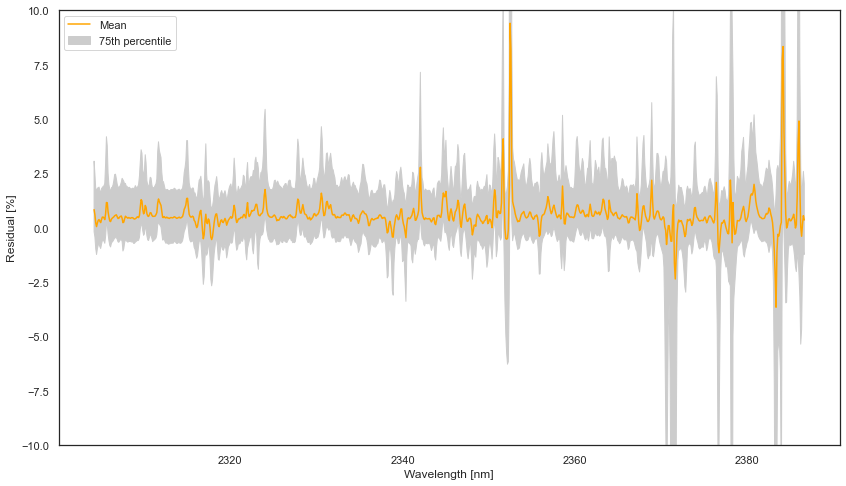

In [24]:
residual = (spectra_test - test_preds) / spectra_test
fig1 = plt.figure(2)
fig1.set_size_inches(14, 8)

    
plt.plot (wl, np.percentile(residual*100, 50, axis=0), "orange")
    
plt.fill_between(wl, np.percentile(residual*100, 25, axis=0), 
                     np.percentile(residual*100, 75, axis=0), color="0.8")
plt.legend(["Mean","75th percentile"], loc="upper left")

plt.ylim([-10,10])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Residual [%]')
plt.show()

### Acknowledgements

this notebook was created, in part, with information obtained from:
* [Artificial Intelligence (AI) for Earth Monitoring](https://www.futurelearn.com/courses/artificial-intelligence-for-earth-monitoring)